# Simulation based inference for simple RL models

### Imports and functions

In [ ]:
from simulation_based_inference.simulation import (
    simulate_multiple_rescorla_wagner_models,
    generate_block_bandit_outcomes,
    simulate_rescorla_wagner_dual,
    simulate_rescorla_wagner_single
)
from simulation_based_inference.npe import NPEModel
from simulation_based_inference.utils import plot_recovery, pp_plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import pingouin as pg
import numpy as np
from tqdm import tqdm

In [2]:
def gen_rescorla_wagner_dual_simulations(n_obs: int = 10000, simulation_seed: int = 42, outcome_seed: int = 42):
    """ Helper function for simulating data """

    rng = np.random.RandomState(simulation_seed)

    alpha = rng.uniform(0, 1, n_obs)
    temperature = rng.uniform(0, 1, n_obs)

    outcomes, _ = generate_block_bandit_outcomes(
        200, 1, 4, seed=outcome_seed  # 4-armed bandit, 200 trials in 1 block
    )

    model_specifications = [
        ('single', simulate_rescorla_wagner_single, [alpha, temperature]),
    ]

    simulations = simulate_multiple_rescorla_wagner_models(
        outcomes,
        model_specifications,
    )
    
    return simulations, outcomes

## Simulate data

Using a simple Rescorla-Wagner model with a single learning rate ($\alpha$) and temperature.

The "task" is a 4 armed bandit with 200 trials. Reward probabilities fluctuate over the course of the task.

In [3]:
simulations_train, outcomes = gen_rescorla_wagner_dual_simulations(n_obs=20000)
simulations_test, _ = gen_rescorla_wagner_dual_simulations(n_obs=500, simulation_seed=43)

## Fit the NPE model

NPE refers to Neural Posterior Estimation (https://www.mackelab.org/sbi/#posterior-estimation-snpe), which learns a function that maps observed behaviour (in this case which stimuli were chosen) on to the posterior distribution of the parameters.

In [4]:
npe = NPEModel()
npe.fit(simulations_train['single']['choices'], simulations_train['single']['params'])

 Neural network successfully converged after 27 epochs.

### Sample from the trained model

In [5]:
sampled_params = npe.sample(simulations_test['single']['choices'], n_samples=2000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 38.46it/s]


### Plot parameter recovery

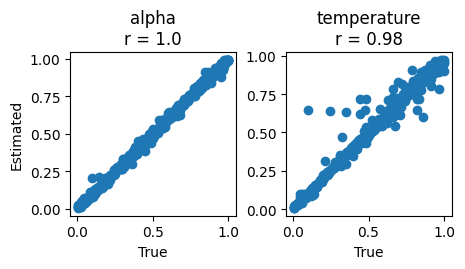

In [6]:
plot_recovery(simulations_test['single']['params'], sampled_params.mean(axis=0), 0, param_names=['alpha', 'temperature'])
# plt.savefig('sbi_recovery.svg')

### Plot posterior calibration using a P-P plot

Well calibrated posteriors should result in a line that lies on the diagonal here. This means that across "subjects", we see that X% of true parameter values are within the Xth percentile of the posterior distribution. E.g., if we see that 5% of true parameter values are within the 5th percentile of the posterior distribution, we can say that the model is well calibrated.

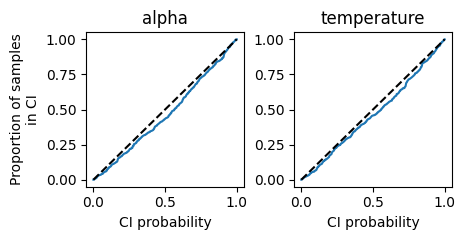

In [7]:
pp_plot(simulations_test['single']['params'], sampled_params.swapaxes(0, 1), 0, param_names=['alpha', 'temperature'])
# plt.savefig('sbi_calibration.svg')

## Group differences

### Specify group parameter differences

First we create a 100 sets of $\alpha$ values, each set containing two groups of 50 subjects. These are required to have a difference between them of 0.05 < $|d|$ < 3.

In [8]:
accepted = 0

rng = np.random.RandomState(42)

param_dists = []
ds = []

while accepted < 100:
    group_a = beta.rvs(rng.random() * 10 + 1, rng.random() * 10 + 1, size=50)
    group_b = beta.rvs(rng.random() * 10 + 1, rng.random() * 10 + 1, size=50)
    
    d = pg.compute_effsize(group_a, group_b, paired=False, eftype='cohen')
    
    if 0.05 < d < 3:
        param_dists.append((group_a, group_b))
        ds.append(d)
        accepted += 1
    

### Simulate data and fit the NPE model

This section simulates data for each set of $\alpha$ values, and fits the NPE model to each set of data. It then samples from the posterior distribution and calculates the recovered effect size.

In [9]:

recovered_ds = []
true_ds = []

for i in tqdm(range(len(param_dists))):

    n_obs = 100

    alpha = np.hstack([param_dists[i][0], param_dists[i][1]])
    temperature = rng.uniform(0, 1, n_obs)

    _, choices, value_estimates = simulate_rescorla_wagner_single(alpha, temperature, outcomes)
       
    samples = npe.sample(choices, progress_bar=False, n_samples=2000)

    param_means = samples.mean(axis=0)

    recovered_ds.append(pg.compute_effsize(param_means[:50, 0], param_means[50:, 0], paired=False, eftype='cohen'))
    true_ds.append(ds[i])




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:20<00:00,  2.61s/it]


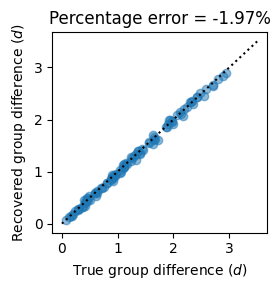

In [11]:
plt.figure(figsize=(3, 3))

plt.scatter(true_ds, recovered_ds, alpha=0.5)
plt.plot([0, 3.5], [0, 3.5], color='black', linestyle=':')
plt.xlabel(r'True group difference ($d$)')
plt.ylabel(r'Recovered group difference ($d$)')
plt.title('Percentage error = {:.2f}%'.format(((np.array(recovered_ds) - np.array(true_ds)) / true_ds).mean() * 100))
plt.tight_layout()
# plt.savefig('sbi_effect_sizes.svg')